In [1]:
#### skip warning if any
import warnings
warnings.filterwarnings('ignore')

In [2]:
#### import all required lib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [5]:
df_test.head(2)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...


In [6]:
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# we can find that only fake news are having text as null, so we can drop respective data with other column containing null values 
df_train[df_train.isnull()['title']==True]['label'].value_counts()

1    558
Name: label, dtype: int64

In [8]:
df_train['title'].fillna('Fake Fake Fake',inplace=True)

In [9]:
df_train.isnull().sum()

id           0
title        0
author    1957
text        39
label        0
dtype: int64

In [10]:
len(df_train[df_train['title']=='Fake Fake Fake'])

558

In [11]:
df_test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [12]:
df_test['title'].fillna('Fake Fake Fake',inplace=True)

In [13]:
df_test.isnull().sum()

id          0
title       0
author    503
text        7
dtype: int64

In [14]:
len(df_test[df_test['title']=='Fake Fake Fake'])

122

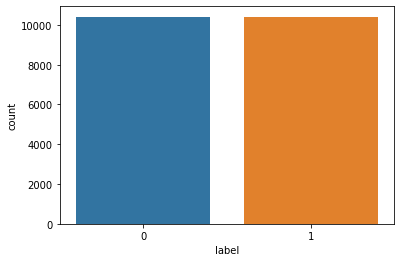

In [15]:
##### we will try to visualize some distribution, so using countplot data is not imbalanced
sns.countplot(df_train['label'])

In [16]:
#### import NLP specific data pre-processing libraries
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import re

In [17]:
#### function for cleaning text like remove punctuations, digits and other than alphabet word
def text_analyzer(messages):
    porter = PorterStemmer()
    clean_corpus = []
    
    for i in range(len(messages)):
        
        text = messages.iloc[i]
        clean_text = re.sub('[^a-zA-Z]',' ',text)
        
        clean_text = clean_text.lower()
        clean_text = clean_text.split()
        
        clean_text = [porter.stem(word) for word in clean_text if word not in stopwords.words('english')]
        clean_text = ' '.join(clean_text)
        
        clean_corpus.append(clean_text)
        
    return clean_corpus
    

In [18]:
print(len(df_train))


20800


In [19]:
train_clean_messages = text_analyzer(df_train['title'])

In [20]:
train_clean_messages[:10]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'life life luxuri elton john favorit shark pictur stare long transcontinent flight',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'excerpt draft script donald trump q ampa black church pastor new york time',
 'back channel plan ukrain russia courtesi trump associ new york time']

In [21]:
#### we will work on Word embedding now
#### declare variable vocabulary size
voc_size = 5000

In [22]:
max_len = 0
for msg in train_clean_messages:
    msg_len = len(msg.split())
    if msg_len > max_len:
        max_len=msg_len

print('Max Sentence lenght in training corpus is',max_len)

Max Sentence lenght in training corpus is 47


In [24]:
# so we will set sentence lenght to 40 as in testing corpus max sentence lenght is 27
sent_len=40
# we will set dimention as 40
dim=40 

In [25]:
#### we will import some packages which are required for one hot representation
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

Using TensorFlow backend.


In [26]:
def get_embedded_corpus(vocsize,sentlen,message):
    try:
        one_hot_corpus = [one_hot(word,vocsize) for word in message]
        padded_corpus = pad_sequences(one_hot_corpus,padding='pre',maxlen=sentlen)
    except e:
        print('exception is',e)
    finally:
        return padded_corpus

In [27]:
cleaned_word_corpus=get_embedded_corpus(voc_size,sent_len,train_clean_messages)

In [28]:
len(cleaned_word_corpus)

20800

In [29]:
cleaned_word_corpus[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2782, 4335, 3864,
        1359,  485, 2665,  957, 1269, 3091,  895],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        2931, 1784,  952,  345, 1310, 1983, 4333]])

In [30]:
#### now we will create neural network for text classification
#### import required lib for the same
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout

In [31]:
# import models for hyper parameter tuning
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(layers):
    model = Sequential()
    
    for i,nodes in enumerate(layers):
        if i==0:
            model.add(Embedding(voc_size,dim,input_length=sent_len))
            model.add(Dropout(0.2))
            model.add(LSTM(nodes))       
            model.add(Dropout(0.2))
        elif i==1:
            model.add(LSTM(nodes))       
            model.add(Dropout(0.2))
        else:
            model.add(Dense(nodes,activation='relu'))
            model.add(Dropout(0.2))


    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [32]:
print('Shape of embedded corpus',cleaned_word_corpus.shape)
print('Type of embedded corpus',type(cleaned_word_corpus))

Shape of embedded corpus (20800, 40)
Type of embedded corpus <class 'numpy.ndarray'>


In [33]:
X=cleaned_word_corpus
y=df_train['label']

In [34]:
print('Shape of label',y.shape)
print('Type of label',type(y))

Shape of label (20800,)
Type of label <class 'pandas.core.series.Series'>


In [35]:
y = np.array(y)
print(y[:5])
print('Type of label',type(y))

[1 0 1 1 1]
Type of label <class 'numpy.ndarray'>


In [36]:
#### we will now train and fit the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [37]:
model = KerasClassifier(build_fn=create_model)

layers = [(100,),(50,50),(50,100,100,50)]

param_grid = dict(layers=layers,batch_size=[128,256],epochs=[10])
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=5)

grid_result = grid.fit(X,y)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
16640/16640 [==============================] - 16s 989us/step - loss: 0.4077 - accuracy: 0.8263
Epoch 2/10
16640/16640 [==============================] - 15s 902us/step - loss: 0.1586 - accuracy: 0.9386s -
Epoch 3/10
16640/16640 [==============================] - 10s 622us/step - loss: 0.1156 - accuracy: 0.9562
Epoch 4/10
16640/16640 [==============================] - 15s 885us/step - loss: 0.0901 - accuracy: 0.9659
Epoch 5/10
16640/16640 [==============================] - 15s 899us/step - loss: 0.0688 - accuracy: 0.9758
Epoch 6/10
16640/16640 [==============================] - 15s 879us/step - loss: 0.0541 - accuracy: 0.9825
Epoch 7/10
16640/16640 [==============================] - 15s 881us/step - loss: 0.0401 - accuracy: 0.9867
Epoch 8/10
16640/16640 [==============================] - 13s 809us/step - loss: 0.0283 - accuracy: 0.9910
Epoch 9/10
16640/16640 [======================

16640/16640 [==============================] - 37s 2ms/step - loss: 0.0329 - accuracy: 0.9898
Epoch 10/10
4160/4160 [==============================] - 5s 1ms/step
Epoch 1/10
16640/16640 [==============================] - 41s 2ms/step - loss: 0.5548 - accuracy: 0.7395
Epoch 2/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.2321 - accuracy: 0.9119
Epoch 3/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.1414 - accuracy: 0.9458
Epoch 4/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.1038 - accuracy: 0.9626
Epoch 5/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.0837 - accuracy: 0.9716
Epoch 6/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.0631 - accuracy: 0.9809
Epoch 7/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.0495 - accuracy: 0.9839
Epoch 8/10
16640/16640 [==============================] - 21s 1ms/step - loss: 0.0388 - accuracy: 0.98

In [38]:
##### we will check classification report and confusion matrix for calculating accuracy
from sklearn.metrics import classification_report,confusion_matrix

In [39]:
best_param = grid_result.best_params_

# predict output
y_pred = grid_result.predict(X_test)

In [40]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3441    8]
 [  14 3401]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3449
           1       1.00      1.00      1.00      3415

    accuracy                           1.00      6864
   macro avg       1.00      1.00      1.00      6864
weighted avg       1.00      1.00      1.00      6864



In [41]:
best_param

{'batch_size': 128, 'epochs': 10, 'layers': (100,)}

In [42]:
[int(i) for i in y_pred]

[1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,


In [43]:
#### now we will try to fit this model on test data
submission = pd.read_csv('submit.csv')
submission.head(5)

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [44]:
print('length of submission df',len(submission))
print('length of test df (null already removed)',len(df_test))

length of submission df 5200
length of test df (null already removed) 5200


In [45]:
test_df = pd.merge(df_test,submission,how='inner')[['title','label']]

In [46]:
test_df.head(5)

,title,label
0,"Specter of Trump Loosens Tongues, if Not Purse...",0
1,Russian warships ready to strike terrorists ne...,1
2,#NoDAPL: Native American Leaders Vow to Stay A...,0
3,"Tim Tebow Will Attempt Another Comeback, This ...",1
4,Keiser Report: Meme Wars (E995),1


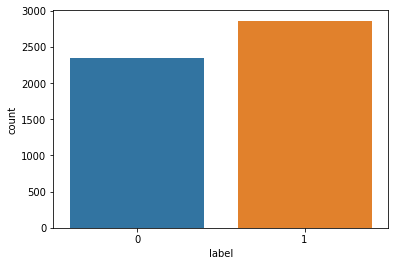

In [47]:
sns.countplot(test_df['label'])

In [48]:
test_clean_messages = text_analyzer(test_df['title'])

In [49]:
max_len = 0
for msg in test_clean_messages:
    msg_len = len(msg.split())
    if msg_len > max_len:
        max_len=msg_len

print('Max Sentence lenght in corpus is testing data',max_len)

Max Sentence lenght in corpus is testing data 29


In [50]:
# so we can set sentence lenght as set in training
cleaned_test_word_corpus=get_embedded_corpus(voc_size,sent_len,test_clean_messages)

In [51]:
cleaned_test_word_corpus[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 1613, 2159,  160, 1774,
         912, 3117,  526,  678, 1621, 1726, 2651],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        3069, 1215, 3598, 4905,  242, 1920, 4275],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 1111, 3487, 3685,
        1090, 2212,  121, 4278, 3380,  729, 4822],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [52]:
y_pred_test = grid_result.predict(cleaned_test_word_corpus)
#y_pred = model.predict_classes(X_test)

In [53]:
len(y_pred_test)

5200

In [54]:
real_test_y=list(test_df['label'])

In [55]:
y_pred_test = [int(i) for i in y_pred_test]

In [56]:
y_pred_test[:5]

[0, 1, 0, 0, 0]

In [57]:
real_test_y[:5]

[0, 1, 0, 1, 1]

In [58]:
print(classification_report(real_test_y,y_pred_test))
#print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.66      0.62      2339
           1       0.69      0.62      0.66      2861

    accuracy                           0.64      5200
   macro avg       0.64      0.64      0.64      5200
weighted avg       0.65      0.64      0.64      5200



In [59]:
print(confusion_matrix(real_test_y,y_pred_test))

[[1550  789]
 [1080 1781]]


In [60]:
my_submission = df_test[['id']]
my_submission['label'] = y_pred_test
my_submission.to_csv('my_submission.csv', index = False)

In [61]:
#we will dump model now
import pickle
file_ip=open('ModelFakeClassifier.pkl','wb')
pickle.dump(grid_result,file_ip)

file_ip.close()